<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/experiments_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [721]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

!pip install dict_minimize
from dict_minimize.torch_api import minimize
from collections import OrderedDict

# Helpers for plotting the trajectories of the weights of the neurons

In [722]:
def plot_trajectories(data_row):
  convergence_neurons_incoming_x = []
  convergence_neurons_incoming_y = []
  convergence_neurons_outgoing = []

  for i in range(0, int(data_row['student size'])):
    neuron_traj_x = np.fromstring(data_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')
    plt.plot(neuron_traj_x, neuron_traj_y)
  
    convergence_neurons_incoming_x.append(neuron_traj_x[-1])
    convergence_neurons_incoming_y.append(neuron_traj_y[-1])

    neuron_a = float(data_row['neuron_' + str(i) + '_a'].values[0])
    convergence_neurons_outgoing.append(neuron_a)

  teacher_neurons_x = np.fromstring(data_row['teacher_neurons_x'].values[0][1 : -1], dtype=float, sep=',')
  teacher_neurons_y = np.fromstring(data_row['teacher_neurons_y'].values[0][1 : -1], dtype=float, sep=',')
  plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

  plt.scatter(convergence_neurons_incoming_x,
            convergence_neurons_incoming_y,
            c = convergence_neurons_outgoing,
            cmap=matplotlib.cm.jet)
  plt.colorbar()

# Read the data from the .csv file

In [723]:
data = pd.read_csv('experiments_data_student_6_outgoing_1_-1.csv')

# TODO: remove these check and make sure the Hessian is not complex/
data['smallest eigenvalue'] = pd.to_numeric(data['smallest eigenvalue'], 'coerce')
print("Number of complex eigenvalues:", len(data[data['smallest eigenvalue'].isna()]))
data = data[data['smallest eigenvalue'].notna()]
data['loss'] = pd.to_numeric(data['loss'], 'coerce')
data = data[data['loss'].notna()]
data['gradient norm'] = pd.to_numeric(data['gradient norm'], 'coerce')
data = data[data['gradient norm'].notna()]

len(data)

Number of complex eigenvalues: 2


998

In [724]:
data.head()

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
0,7.368996e-08,2.683539e-06,-3.072414e-07,6,"[0.6980545, 0.6969546, 0.69595534, 0.69495714,...","[-0.01575166, -0.0146518275, -0.013652729, -0....",-0.300093,"[0.47843462, 0.47953442, 0.48053354, 0.4815314...","[0.21780246, 0.21670271, 0.21570413, 0.2147074...",0.534985,"[-0.278064, -0.27916375, -0.28016242, -0.28115...","[0.22209495, 0.22099163, 0.21997482, 0.2189388...",-1.228895,"[-0.5253651, -0.52426493, -0.52326477, -0.5222...","[0.11097568, 0.10987543, 0.10887405, 0.1078707...",0.701700,"[-0.39972517, -0.39862496, -0.39762387, -0.396...","[-0.61575437, -0.61685455, -0.61785483, -0.618...",0.780308,"[-0.036501527, -0.03760135, -0.038600408, -0.0...","[-0.49979421, -0.49869436, -0.4976945, -0.4966...",-0.488004,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
1,1.086262e-07,1.747063e-06,-3.806967e-08,6,"[-0.6043891, -0.6032889, -0.6022887, -0.601288...","[-0.058547854, -0.059647463, -0.06064533, -0.0...",1.515955,"[-0.7961307, -0.79723024, -0.79822767, -0.7992...","[-0.55460167, -0.5535022, -0.55250525, -0.5515...",-0.917856,"[-0.47430068, -0.47540027, -0.4763981, -0.4773...","[-0.42227766, -0.42117822, -0.42018124, -0.419...",-0.744507,"[-0.6128353, -0.61393505, -0.61493355, -0.6159...","[0.39448422, 0.39338267, 0.3923741, 0.39135426...",-0.076032,"[0.8487162, 0.8476165, 0.84661824, 0.84562236,...","[0.68875355, 0.6898531, 0.69085044, 0.69184405...",-0.749196,"[0.50306565, 0.50416595, 0.5051673, 0.5061707,...","[-0.1113919, -0.11249129, -0.113487914, -0.114...",0.971635,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
2,1.008812e-07,1.146478e-06,-6.748910e-07,6,"[0.8127845, 0.81168455, 0.81068516, 0.80968654...","[0.6718052, 0.6729051, 0.6739043, 0.6749023, 0...",-0.506687,"[-0.52905494, -0.52795506, -0.52695584, -0.525...","[0.571407, 0.57250684, 0.5735055, 0.5745024, 0...",0.829806,"[-0.8023246, -0.80122495, -0.8002272, -0.79923...","[0.79862326, 0.7997228, 0.80072004, 0.8017135,...",-0.126239,"[-0.73665804, -0.7355583, -0.73455983, -0.7335...","[0.13758999, 0.13868995, 0.13968965, 0.1406889...",-0.973729,"[0.11645836, 0.11535863, 0.11436017, 0.1133638...","[0.54036874, 0.5414682, 0.5424652, 0.54345804,...",-0.202526,"[0.17881507, 0.17771532, 0.17671676, 0.1757201...","[-0.11210662, -0.113206185, -0.11420382, -0.11...",0.979374,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
3,1.106605e-07,1.992916e-06,-6.465805e-07,6,"[-0.45053408, -0.44943398, -0.44843364, -0.447...","[-0.37833294, -0.37723523, -0.376248, -0.37527...",0.735935,"[0.78767174, 0.78655374, 0.7854719, 0.78431064...","[-0.7210004, -0.7221184, -0.72319984, -0.72436...",-0.735639,"[-0.00064349174, -0.0017435071, -0.0027435902,...","[-0.80965626, -0.8107556, -0.81175184, -0.8127...",-0.700970,"[0.42528814, 0.42638797, 0.42738724, 0.4283854...","[-0.69517016, -0.6940703, -0.693071, -0.692072...",0.734697,"[0.84347874, 0.84237844, 0.8413771, 0.840374, ...","[-0.604022, -0.6051222, -0.60612285, -0.607124...",0.267892,"[-0.056492925, -0.057593092, -0.05859396, -0.0...","[0.35165137, 0.35055152, 0.34955165, 0.3485517...",-0.301916,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
4,9.026246e-05,9.900671e-07,2.736716e-08,6,"[0.67343026, 0.67233086, 0.671334, 0.6703415, ...","[-0.62559295, -0.6266925, -0.62768954, -0.6286...",-0.480798,"[0.36074752, 0.361847, 0.36284435, 0.3638382, ...","[-0.23552644, -0.2344266, -0.23342751, -0.2324...",0.965822,"[0.72926074, 0.73036045, 0.7313585, 0.7323539,...","[-0.54830503, -0.54720515, -0.54620606, -0.545...",0.830935,"[-0.01631403, -0.017413458, -0.018410342, -0.0...","[0.106199324, 0.105099544, 0.10410077, 0.10310...",-0.416083,"[-0.28019053, -0.28128996, -0.28228694, -0.283...","[

# Second order optimization helpers

A dummy network that receives as input the precomputed incoming and outgoing weights and sets them directly.

In [725]:
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

Some configuration for the model, the dataset and the corresponding labels.

In [726]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [727]:
D_in, H_teacher, H_student, D_out = 2, 4, data['student size'].values[0], 1

def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

dataset = torch.Tensor(construct_dataset()) 
print(len(construct_dataset()))

1681


In [728]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(dataset).detach()

Function useful for computing the Hessian.

In [729]:
def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    grad_norm = torch.norm(g_vector)
    l = g_vector.size(0)
    hessian = torch.zeros(l, l)
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd: 
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
    hessian[:, idx] = g2
    return grad_norm.cpu().data.numpy(), hessian.cpu().data.numpy()

A method which computes the derivatives of the objective loss with respect to the incoming and outgoing weights.

In [730]:
def d_loss(params):
  w_in, w_out = params["w_in"], params["w_out"]
  dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
  obj = nn.MSELoss()(dummy_model(dataset), y_labels)
  dw_in, dw_out = torch.autograd.grad(obj, dummy_model.parameters())
  d_obj = OrderedDict([("w_in", dw_in), ("w_out", dw_out)])
  return obj, d_obj

# Case 1: positive eigenvalues

This is certainly:
- either a local minimum
- or a global minimum

In [731]:
positive_eigenvalues_data = data[data['smallest eigenvalue'] >= 0]
positive_eigenvalues_data.head()

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
4,9.026246e-05,9.900671e-07,2.736716e-08,6,"[0.67343026, 0.67233086, 0.671334, 0.6703415, ...","[-0.62559295, -0.6266925, -0.62768954, -0.6286...",-0.480798,"[0.36074752, 0.361847, 0.36284435, 0.3638382, ...","[-0.23552644, -0.2344266, -0.23342751, -0.2324...",0.965822,"[0.72926074, 0.73036045, 0.7313585, 0.7323539,...","[-0.54830503, -0.54720515, -0.54620606, -0.545...",0.830935,"[-0.01631403, -0.017413458, -0.018410342, -0.0...","[0.106199324, 0.105099544, 0.10410077, 0.10310...",-0.416083,"[-0.28019053, -0.28128996, -0.28228694, -0.283...","[0.29820317, 0.29710346, 0.29610485, 0.2951082...",-0.353398,"[0.8347468, 0.83584714, 0.83684903, 0.83785367...","[0.5567817, 0.5556817, 0.5546822, 0.5536834, 0...",-0.546486,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
7,1.402854e-07,2.067346e-06,1.919022e-07,6,"[-0.7755034, -0.7744032, -0.77340364, -0.77240...","[-0.2336052, -0.2347052, -0.23570502, -0.23670...",0.408031,"[0.3885352, 0.38963437, 0.3906299, 0.39161918,...","[0.71373814, 0.7126388, 0.71164274, 0.710652, ...",-0.465399,"[0.3984241, 0.39732435, 0.39632568, 0.3953288,...","[-0.40704444, -0.4081441, -0.40914232, -0.4101...",-0.698984,"[0.09859049, 0.099690184, 0.10068846, 0.101684...","[-0.3339343, -0.3350336, -0.33602968, -0.33702...",0.973073,"[-0.13595033, -0.13705035, -0.1380505, -0.1390...","[-0.57695246, -0.5758522, -0.574851, -0.573848...",-0.689686,"[0.4930218, 0.49412206, 0.49512357, 0.4961271,...","[0.454328, 0.45322764, 0.45222583, 0.45122164,...",0.472965,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
9,2.766455e-07,3.115356e-06,7.796185e-08,6,"[-0.32134587, -0.32024541, -0.31924298, -0.318...","[-0.20258403, -0.20368439, -0.2046862, -0.2056...",-0.555447,"[0.60952467, 0.60842526, 0.60742843, 0.6064359...","[0.30937237, 0.31047156, 0.31146747, 0.3124577...",0.666453,"[-0.4912904, -0.49019083, -0.48919323, -0.4881...","[-0.5285406, -0.52964, -0.5306367, -0.5316288,...",-1.007267,"[0.07966131, 0.0785616, 0.07756317, 0.07656689...","[-0.7042102, -0.7031106, -0.70211285, -0.70111...",0.577087,"[0.33110088, 0.3322117, 0.33326384, 0.33437282...","[-0.6604708, -0.6593711, -0.658373, -0.6573776...",0.447884,"[0.65720886, 0.6561095, 0.6551133, 0.65412235,...","[0.7533205, 0.7544196, 0.7554148, 0.7564034, 0...",-0.128708,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
14,1.226534e-07,2.008618e-06,1.608297e-07,6,"[0.22523838, 0.2241391, 0.22314294, 0.22215208...","[0.29589146, 0.29479197, 0.29379448, 0.2928005...",0.774795,"[0.70528203, 0.7041822, 0.7031834, 0.70218635,...","[0.59785694, 0.598957, 0.5999566, 0.6009554, 0...",-0.741074,"[-0.14219213, -0.14329173, -0.14428958, -0.145...","[0.080355704, 0.07925618, 0.07825877, 0.077264...",-0.040736,"[-0.0797084, -0.08080796, -0.081805594, -0.082...","[-0.5046653, -0.5057642, -0.50675786, -0.50774...",-0.723692,"[0.35252672, 0.35362652, 0.35462564, 0.3556235...","[-0.62000716, -0.6189072, -0.6179078, -0.61690...",0.951538,"[-0.25257778, -0.25367734, -0.25467494, -0.255...","[-0.12443668, -0.12553595, -0.12653211, -0.127...",-0.220831,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
20,8.202739e-08,1.263754e-06,5.667045e-07,6,"[-0.7552683, -0.75416815, -0.7531686, -0.75216...","[0.27841407, 0.27731436, 0.27631584, 0.2753192...",-0.433181,"[0.53271705, 0.53381634, 0.53481215, 0.5358022...","[0.75325614, 0.7521568, 0.75116074, 0.75017005...",-0.759575,"[-0.11022884, -0.109128945, -0.10812957, -0.10...","[0.043808937, 0.04270915, 0.04171031, 0.040713...",0.575051,"[-0.7493745, -0.7482743, -0.74727464, -0.74627...","[0.6195689, 0.6184728, 0.6174953, 0.61655146, ...",0.754421,"[0.21978968, 0.22088909, 0.22188582, 0.2228780...","[-0

## Choose the entry with the highest loss for visual inspection.

In [732]:
highest_loss_row = positive_eigenvalues_data[positive_eigenvalues_data['loss'] == 
                          max(positive_eigenvalues_data['loss'])]
highest_loss_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
96,0.000114,0.000002,4.521153e-08,6,"[-0.18988657, -0.19098668, -0.19198729, -0.192...","[-0.4577395, -0.45663914, -0.45563725, -0.4546...",-0.439335,"[0.076085806, 0.07718549, 0.078183755, 0.07917...","[0.49852616, 0.49742618, 0.49642602, 0.4954258...",0.546022,"[-0.2843222, -0.285422, -0.28642118, -0.287419...","[-0.40905708, -0.40795702, -0.40695682, -0.405...",-0.271234,"[-0.5915655, -0.5904664, -0.58947104, -0.58848...","[-0.35449505, -0.35559425, -0.35658985, -0.357...",-0.125916,"[-0.79388064, -0.7927811, -0.791784, -0.790790...","[-0.36374694, -0.36484644, -0.36584392, -0.366...",-0.061185,"[0.2055226, 0.20662214, 0.20761958, 0.20861349...","[-0.35181528, -0.35291502, -0.3539138, -0.3549...",0.351647,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


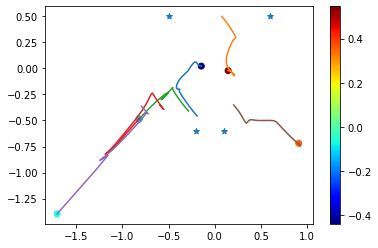

In [733]:
plot_trajectories(highest_loss_row)

## Choose the entry with the lowest loss for visual inspection.

In [734]:
lowest_loss_row = positive_eigenvalues_data[positive_eigenvalues_data['loss'] == 
                          min(positive_eigenvalues_data['loss'])]
lowest_loss_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
146,2.940080e-09,5.828641e-07,1.564670e-07,6,"[-0.7925467, -0.7914465, -0.7904459, -0.789444...","[-0.22784829, -0.22894914, -0.22995372, -0.230...",0.370681,"[0.74891895, 0.7500189, 0.7510182, 0.7520166, ...","[0.14569956, 0.14678791, 0.14771865, 0.1485413...",1.003134,"[0.7328748, 0.73177356, 0.73076713, 0.72975194...","[0.52823836, 0.5293396, 0.5303463, 0.5313617, ...",-0.555717,"[0.7198315, 0.72092986, 0.7219207, 0.72289866,...","[0.44901675, 0.44791844, 0.44692782, 0.4459504...",-0.448735,"[0.49754864, 0.49864846, 0.49964774, 0.5006460...","[-0.7890209, -0.78792083, -0.78692126, -0.7859...",0.563041,"[0.65730995, 0.65620965, 0.6552083, 0.6542052,...","[-0.0879305, -0.089030765, -0.09003222, -0.091...",-0.932405,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


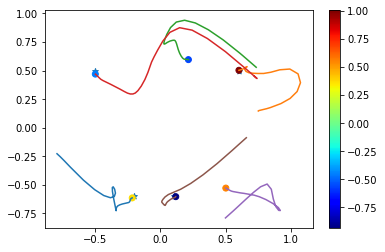

In [735]:
plot_trajectories(lowest_loss_row)

# Case 2: negative eigenvalues

In [736]:
negative_eigenvalues_data = data[data['smallest eigenvalue'] <= 0]
negative_eigenvalues_data.head()

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
0,7.368996e-08,0.000003,-3.072414e-07,6,"[0.6980545, 0.6969546, 0.69595534, 0.69495714,...","[-0.01575166, -0.0146518275, -0.013652729, -0....",-0.300093,"[0.47843462, 0.47953442, 0.48053354, 0.4815314...","[0.21780246, 0.21670271, 0.21570413, 0.2147074...",0.534985,"[-0.278064, -0.27916375, -0.28016242, -0.28115...","[0.22209495, 0.22099163, 0.21997482, 0.2189388...",-1.228895,"[-0.5253651, -0.52426493, -0.52326477, -0.5222...","[0.11097568, 0.10987543, 0.10887405, 0.1078707...",0.701700,"[-0.39972517, -0.39862496, -0.39762387, -0.396...","[-0.61575437, -0.61685455, -0.61785483, -0.618...",0.780308,"[-0.036501527, -0.03760135, -0.038600408, -0.0...","[-0.49979421, -0.49869436, -0.4976945, -0.4966...",-0.488004,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
1,1.086262e-07,0.000002,-3.806967e-08,6,"[-0.6043891, -0.6032889, -0.6022887, -0.601288...","[-0.058547854, -0.059647463, -0.06064533, -0.0...",1.515955,"[-0.7961307, -0.79723024, -0.79822767, -0.7992...","[-0.55460167, -0.5535022, -0.55250525, -0.5515...",-0.917856,"[-0.47430068, -0.47540027, -0.4763981, -0.4773...","[-0.42227766, -0.42117822, -0.42018124, -0.419...",-0.744507,"[-0.6128353, -0.61393505, -0.61493355, -0.6159...","[0.39448422, 0.39338267, 0.3923741, 0.39135426...",-0.076032,"[0.8487162, 0.8476165, 0.84661824, 0.84562236,...","[0.68875355, 0.6898531, 0.69085044, 0.69184405...",-0.749196,"[0.50306565, 0.50416595, 0.5051673, 0.5061707,...","[-0.1113919, -0.11249129, -0.113487914, -0.114...",0.971635,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
2,1.008812e-07,0.000001,-6.748910e-07,6,"[0.8127845, 0.81168455, 0.81068516, 0.80968654...","[0.6718052, 0.6729051, 0.6739043, 0.6749023, 0...",-0.506687,"[-0.52905494, -0.52795506, -0.52695584, -0.525...","[0.571407, 0.57250684, 0.5735055, 0.5745024, 0...",0.829806,"[-0.8023246, -0.80122495, -0.8002272, -0.79923...","[0.79862326, 0.7997228, 0.80072004, 0.8017135,...",-0.126239,"[-0.73665804, -0.7355583, -0.73455983, -0.7335...","[0.13758999, 0.13868995, 0.13968965, 0.1406889...",-0.973729,"[0.11645836, 0.11535863, 0.11436017, 0.1133638...","[0.54036874, 0.5414682, 0.5424652, 0.54345804,...",-0.202526,"[0.17881507, 0.17771532, 0.17671676, 0.1757201...","[-0.11210662, -0.113206185, -0.11420382, -0.11...",0.979374,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
3,1.106605e-07,0.000002,-6.465805e-07,6,"[-0.45053408, -0.44943398, -0.44843364, -0.447...","[-0.37833294, -0.37723523, -0.376248, -0.37527...",0.735935,"[0.78767174, 0.78655374, 0.7854719, 0.78431064...","[-0.7210004, -0.7221184, -0.72319984, -0.72436...",-0.735639,"[-0.00064349174, -0.0017435071, -0.0027435902,...","[-0.80965626, -0.8107556, -0.81175184, -0.8127...",-0.700970,"[0.42528814, 0.42638797, 0.42738724, 0.4283854...","[-0.69517016, -0.6940703, -0.693071, -0.692072...",0.734697,"[0.84347874, 0.84237844, 0.8413771, 0.840374, ...","[-0.604022, -0.6051222, -0.60612285, -0.607124...",0.267892,"[-0.056492925, -0.057593092, -0.05859396, -0.0...","[0.35165137, 0.35055152, 0.34955165, 0.3485517...",-0.301916,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"
5,1.114575e-07,0.000002,-4.608297e-07,6,"[0.39266485, 0.39375186, 0.39467108, 0.3954455...","[-0.7363104, -0.7352233, -0.7343034, -0.733527...",-0.694181,"[0.15991634, 0.1610161, 0.16201484, 0.16301182...","[0.42293245, 0.42403165, 0.42502758, 0.4260179...",1.318266,"[-0.57505906, -0.5739589, -0.572959, -0.571959...","[-0.23046052, -0.22936043, -0.22835992, -0.227...",0.848714,"[-0.06715804, -0.06825814, -0.06925862, -0.070...","[0.80777353, 0.80667317, 0.8056715, 0.80466765...",-0.940161,"[0.32318276, 0.322083, 0.321084, 0.32008636, 0...","[0.74564785, 0.74674

In [737]:
len(negative_eigenvalues_data)

692

## Choose an experiment with the (negative) eigenvalue with the highest magnitude - indicative of a saddle.

In [738]:
smallest_neg_eigenvalue_row = negative_eigenvalues_data[negative_eigenvalues_data['smallest eigenvalue'] == 
                          min(negative_eigenvalues_data['smallest eigenvalue'])]
smallest_neg_eigenvalue_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
536,0.000117,0.000002,-0.000013,6,"[0.07326281, 0.07436205, 0.07535785, 0.0763478...","[-0.32001853, -0.32111785, -0.32211435, -0.323...",-0.085921,"[0.63008505, 0.6311847, 0.63218266, 0.63317776...","[0.4012285, 0.40012878, 0.39913023, 0.39813367...",0.369791,"[0.5624909, 0.5635905, 0.5645884, 0.56558347, ...","[0.50618035, 0.5050806, 0.50408214, 0.503086, ...",0.047371,"[-0.49323797, -0.49213737, -0.49113414, -0.490...","[0.5495127, 0.55061346, 0.5516176, 0.55262727,...",-0.341841,"[-0.35006642, -0.34896633, -0.34796572, -0.346...","[0.6900955, 0.6889956, 0.6879963, 0.6869981, 0...",0.384194,"[-0.30538696, -0.30648682, -0.3074863, -0.3084...","[-0.031351686, -0.030251574, -0.02925098, -0.0...",-0.373595,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


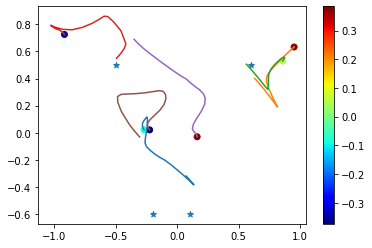

In [739]:
plot_trajectories(smallest_neg_eigenvalue_row)

### Second order optimization starting with the point of convergence.

Firstly, we fetch the weights from the student network.

In [740]:
w_in = []
w_out = []

for i in range(0, int(smallest_neg_eigenvalue_row['student size'])):
  neuron_traj_x = np.fromstring(smallest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
  neuron_traj_y = np.fromstring(smallest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')

  w_in.append([neuron_traj_x[-1], neuron_traj_y[-1]])

  w_out.append(float(smallest_neg_eigenvalue_row['neuron_' + str(i) + '_a'].values[0]))

w_out = [w_out]

print(w_in)
print(w_out)

[[-0.26982093, 0.021385968], [0.9504737, 0.6333818], [0.85748494, 0.5301233], [-0.9166259, 0.7256652], [0.1619739, -0.030009301], [-0.22400174, 0.0209027]]
[[-0.085920654, 0.36979118, 0.047371015, -0.34184116, 0.38419384, -0.3735952]]


Secondly, we apply second order optimization from these weights.



In [741]:
params = OrderedDict([("w_in", torch.Tensor(w_in)), ("w_out", torch.Tensor(w_out))])
lb_dict = OrderedDict([("w_in", torch.Tensor(w_in) - 1), ("w_out", torch.Tensor(w_out) - 1)])
ub_dict = OrderedDict([("w_in", torch.Tensor(w_in) + 1), ("w_out", torch.Tensor(w_out) + 1)])
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
loss_before_optimization = nn.MSELoss()(dummy_model(dataset), y_labels).item()
print('loss before optimization: ', loss_before_optimization)
print('old params: ',params)
# params = minimize(d_loss, params, method="", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 3}, tol=1e-8)
params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
                  options={"disp": True , "maxiter": 10 ** 4}, tol=1e-60)
print('new params: ',params)

loss before optimization:  0.00011658672883640975
old params:  OrderedDict([('w_in', tensor([[-0.2698,  0.0214],
        [ 0.9505,  0.6334],
        [ 0.8575,  0.5301],
        [-0.9166,  0.7257],
        [ 0.1620, -0.0300],
        [-0.2240,  0.0209]])), ('w_out', tensor([[-0.0859,  0.3698,  0.0474, -0.3418,  0.3842, -0.3736]]))])
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00011658669245662168
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
new params:  OrderedDict([('w_in', tensor([[-0.2698,  0.0214],
        [ 0.9505,  0.6334],
        [ 0.8575,  0.5301],
        [-0.9166,  0.7257],
        [ 0.1620, -0.0300],
        [-0.2240,  0.0209]], requires_grad=True)), ('w_out', tensor([[-0.0859,  0.3698,  0.0474, -0.3418,  0.3842, -0.3736]],
       requires_grad=True))])


New smallest eigenvalue after second order optimization.

In [742]:
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
print('loss after optimization: ', nn.MSELoss()(dummy_model(dataset), y_labels))
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
print('new smallest eigenvelue:', smallest_eigenvalue)

loss after optimization:  tensor(0.0001, grad_fn=<MseLossBackward0>)
new smallest eigenvelue: -1.284889e-05


## Choose an experiment with the (negative) eigenvalue with the smallest magnitude - indicative of a local/global minimum.

In [743]:
highest_neg_eigenvalue_row = negative_eigenvalues_data[negative_eigenvalues_data['smallest eigenvalue'] == 
                          max(negative_eigenvalues_data['smallest eigenvalue'])]
highest_neg_eigenvalue_row

,loss,gradient norm,smallest eigenvalue,student size,neuron_0_traj_x,neuron_0_traj_y,neuron_0_a,neuron_1_traj_x,neuron_1_traj_y,neuron_1_a,neuron_2_traj_x,neuron_2_traj_y,neuron_2_a,neuron_3_traj_x,neuron_3_traj_y,neuron_3_a,neuron_4_traj_x,neuron_4_traj_y,neuron_4_a,neuron_5_traj_x,neuron_5_traj_y,neuron_5_a,teacher_neurons_x,teacher_neurons_y
296,0.000114,0.000001,-1.068932e-10,6,"[-0.0039440393, -0.00284374, -0.0018421245, -0...","[0.25338978, 0.25228947, 0.25128788, 0.2502841...",0.399685,"[-0.3325253, -0.3314255, -0.3304262, -0.329427...","[0.750817, 0.74971706, 0.7487177, 0.7477193, 0...",0.528671,"[-0.33830953, -0.33940962, -0.34041017, -0.341...","[0.489541, 0.49064082, 0.4916401, 0.49263835, ...",-0.356121,"[0.30212075, 0.3010209, 0.30002123, 0.2990221,...","[-0.49131992, -0.49022007, -0.48922068, -0.488...",-0.258732,"[0.43859833, 0.43749905, 0.4365028, 0.4355119,...","[-0.6636546, -0.66255546, -0.6615599, -0.66057...",0.061929,"[0.26812845, 0.2670286, 0.26602894, 0.26502982...","[-0.5459701, -0.54487, -0.54387045, -0.5428715...",-0.375432,"[0.6, -0.5, -0.2, 0.1]","[0.5, 0.5, -0.6, -0.6]"


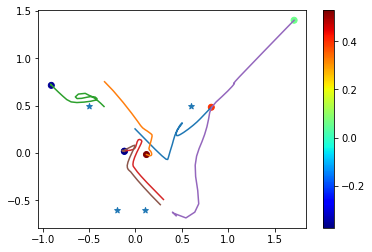

In [744]:
plot_trajectories(highest_neg_eigenvalue_row)

### Second order optimization starting with the point of convergence.

Firstly, we fetch the weights from the student network.

In [745]:
w_in = []
w_out = []

for i in range(0, int(highest_neg_eigenvalue_row['student size'])):
  neuron_traj_x = np.fromstring(highest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_x'].values[0][1:-1], dtype=float, sep=',')
  neuron_traj_y = np.fromstring(highest_neg_eigenvalue_row['neuron_' + str(i) + '_traj_y'].values[0][1:-1], dtype=float, sep=',')

  w_in.append([neuron_traj_x[-1], neuron_traj_y[-1]])

  w_out.append(float(highest_neg_eigenvalue_row['neuron_' + str(i) + '_a'].values[0]))

w_out = [w_out]

print(w_in)
print(w_out)

[[0.81760836, 0.481559], [0.11889681, -0.01725978], [-0.90624803, 0.7126862], [-0.11890284, 0.017259931], [1.7099305, 1.3994889], [-0.11890326, 0.017260088]]
[[0.39968458, 0.5286705, -0.3561207, -0.25873223, 0.06192935, -0.37543166]]


Secondly, we apply second order optimization from these weights.



In [746]:
params = OrderedDict([("w_in", torch.Tensor(w_in)), ("w_out", torch.Tensor(w_out))])
lb_dict = OrderedDict([("w_in", torch.Tensor(w_in) - 1), ("w_out", torch.Tensor(w_out) - 1)])
ub_dict = OrderedDict([("w_in", torch.Tensor(w_in) + 1), ("w_out", torch.Tensor(w_out) + 1)])
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
loss_before_optimization = nn.MSELoss()(dummy_model(dataset), y_labels).item()
print('loss before optimization: ', loss_before_optimization)
print('old params: ',params)
# params = minimize(d_loss, params, method="", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 3}, tol=1e-8)
params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
                  options={"disp": True , "maxiter": 10 ** 4}, tol=1e-60)
print('new params: ',params)

loss before optimization:  0.00011431219172663987
old params:  OrderedDict([('w_in', tensor([[ 0.8176,  0.4816],
        [ 0.1189, -0.0173],
        [-0.9062,  0.7127],
        [-0.1189,  0.0173],
        [ 1.7099,  1.3995],
        [-0.1189,  0.0173]])), ('w_out', tensor([[ 0.3997,  0.5287, -0.3561, -0.2587,  0.0619, -0.3754]]))])
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00011431219172663987
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
new params:  OrderedDict([('w_in', tensor([[ 0.8176,  0.4816],
        [ 0.1189, -0.0173],
        [-0.9062,  0.7127],
        [-0.1189,  0.0173],
        [ 1.7099,  1.3995],
        [-0.1189,  0.0173]], requires_grad=True)), ('w_out', tensor([[ 0.3997,  0.5287, -0.3561, -0.2587,  0.0619, -0.3754]],
       requires_grad=True))])


New smallest eigenvalue after second order optimization.

In [747]:
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
print('loss after optimization: ', nn.MSELoss()(dummy_model(dataset), y_labels))
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(dataset), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
print('new smallest eigenvelue:', smallest_eigenvalue)

loss after optimization:  tensor(0.0001, grad_fn=<MseLossBackward0>)
new smallest eigenvelue: -1.1005273e-10


# How many are global minima?

In [748]:
len(data[data['loss'] <= 1e-8])

44